In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pycountry
import pyprind

plt.style.use("ggplot")
%matplotlib inline
%load_ext jupyter_black

# Import data

## Vaccination data

In [2]:
ds_vax = xr.load_dataset("data/ds_ecdc.nc")
ds_vax = ds_vax.rename({"TargetGroup": "age", "ReportingCountry": "location"})
ds_vax

<xarray.Dataset>
Dimensions:              (date: 147, location: 30, age: 17, Vaccine: 19)
Coordinates:
  * date                 (date) datetime64[ns] 2020-12-16 ... 2023-10-01
  * location             (location) <U2 'AT' 'BE' 'BG' 'CY' ... 'SE' 'SI' 'SK'
  * age                  (age) <U8 '1_Age60+' '1_Age<60' 'ALL' ... 'HCW' 'LTCF'
  * Vaccine              (Vaccine) <U9 'AZ' 'BECNBG' 'BHACOV' ... 'UNK' 'VLA'
Data variables: (12/14)
    Denominator          (date, location, age, Vaccine) float64 nan nan ... nan
    NumberDosesReceived  (date, location, age, Vaccine) float64 nan nan ... nan
    NumberDosesExported  (date, location, age, Vaccine) float64 nan nan ... nan
    FirstDose            (date, location, age, Vaccine) float64 nan nan ... nan
    FirstDoseRefused     (date, location, age, Vaccine) float64 nan nan ... nan
    SecondDose           (date, location, age, Vaccine) float64 nan nan ... nan
    ...                   ...
    DoseAdditional3      (date, location, age, Vaccine) float64 nan nan ... nan
    DoseAdditional4      (date, location, age, Vaccine) float64 nan nan ... nan
    DoseAdditional5      (date, location, age, Vaccine) float64 nan nan ... nan
    UnknownDose          (date, location, age, Vaccine) float64 nan nan ... nan
    Population           (date, location, age, Vaccine) float64 nan nan ... nan
    NumberDosesInjected  (date, location, age, Vaccine) float64 nan nan ... nan

### Data exploration

In [3]:
# FirstDoseRefused, full of nan... Can't do anything from that
# # ds_vax.FirstDoseRefused.sel(Vaccine="UNK").plot(hue="age", col="location", col_wrap=5)

C:\Users\romai\AppData\Local\Temp\ipykernel_13632\3226587779.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["age"])


Text(0, 0.5, 'Millions of units')

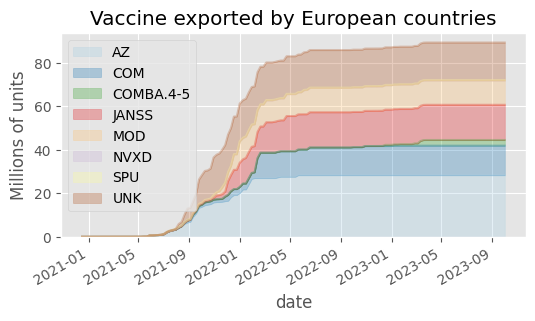

In [3]:
# Number of dose exported
dfp = (
    ds_vax.NumberDosesExported.sel(age="ALL")
    .sum("location")
    .drop(["age"])
    .to_dataset("Vaccine")
    .to_dataframe()
)
dfp = dfp.T[dfp.max() > 0].T
dfp = dfp.cumsum()
fig, ax = plt.subplots(figsize=(6, 3))
(dfp / 1e6).plot(ax=ax, cmap="Paired", kind="area", stacked=True, alpha=0.3)
ax.set_title("Vaccine exported by European countries")
ax.set_ylabel("Millions of units")

Text(0, 0.5, 'Person')

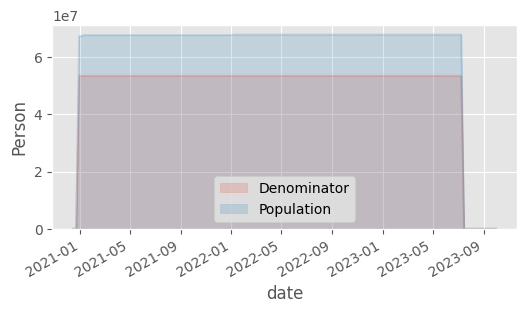

In [4]:
# Target population and population
country = "FR"
age = "ALL"

fig, ax = plt.subplots(figsize=(6, 3))
dfp = (
    ds_vax.sel(location=country, age=age)
    .max("Vaccine")[["Denominator", "Population"]]
    .to_dataframe()
)
dfp.plot(ax=ax, kind="area", stacked=False, alpha=0.2)
ax.set_ylabel("Person")

C:\Users\romai\AppData\Local\Temp\ipykernel_13632\1420589437.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfp.resample("W").sum().plot(ax=ax)


<Axes: xlabel='date'>

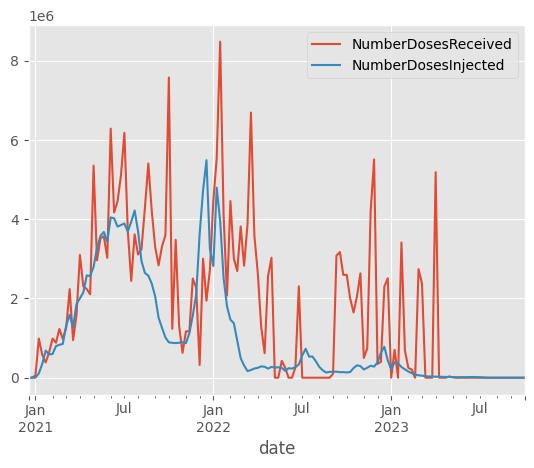

In [5]:
fig, ax = plt.subplots()
dfp = (
    ds_vax[["NumberDosesReceived", "NumberDosesInjected"]]
    .sum("Vaccine")
    .sel(age=age, location=country)
    .to_dataframe()
)
dfp.resample("W").sum().plot(ax=ax)

## Mortality data

### Global montly excess mortality

In [6]:
#Monthly excess mortality data by country
ds_em = xr.load_dataarray("data/ds_demo_mexrt.nc")
ds_em

<xarray.DataArray (date: 53, location: 32)>
array([[ -2.7,  -4.1, -11.8, ...,  -5. ,  -6.1,  -4.4],
       [ -0.8,  -4.9,  -0.2, ...,  -4.7,   0.3,  -1.6],
       [  4.9,  11.8,  -7. , ...,   1.8,  -1.2,   2.1],
       ...,
       [ -0.9,  -8.1, -14.6, ...,  -9.4,  -3.8,  -9.2],
       [  3.8,   2.2, -13.2, ...,  -5.5,   1.6,  -7.6],
       [  7.3,  -2. , -10.9, ...,  -1.2,   1.1,  -4.9]])
Coordinates:
  * date      (date) datetime64[ns] 2020-01-01 2020-02-01 ... 2024-05-01
  * location  (location) <U9 'AT' 'BE' 'BG' 'CH' 'CY' ... 'RO' 'SE' 'SI' 'SK'

### Weekly mortality by age group

In [8]:
ds_ma = xr.load_dataarray("data/ds_demo_r_mwk_05.nc")
ds_ma = ds_ma.sel(sex="T")
ds_ma

<xarray.DataArray (age: 21, location: 39, date: 1282)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [4.140e+02, 4.500e+02, 4.670e+02, ..., 4.000e+02, 3.810e+02,
               nan],
        [1.099e+03, 1.140e+03, 1.257e+03, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [3.400e+01, 5.200e+01, 4.600e+01, ..., 6.600e+01, 9.800e+01,
               nan],
        [6.200e+01, 8.300e+01, 9.000e+01, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [3.000e+00, 2.000e+00, 0.000e+00, ..., 2.000e+00, 1.000e+00,
               nan],
        [1.500e+01, 1.100e+01, 1.200e+01, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]])
Coordinates:
  * age       (age) <U6 'TOTAL' 'UNK' 'Y10-14' ... 'Y85-89' 'Y_GE90' 'Y_LT5'
    sex       <U1 'T'
  * location  (location) <U9 'AD' 'AL' 'AM' 'AT' 'BE' ... 'SE' 'SI' 'SK' 'UK'
  * date      (date) datetime64[ns] 2000-01-02 2000-01-09 ... 2024-07-21

## Population data

In [127]:
ds_pop = xr.load_dataarray("data/ds_demo_pjan.nc")
ds_pop = ds_pop.sel(sex="T").drop_vars("sex")
ds_pop

<xarray.DataArray (age: 103, location: 59, date: 64)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [1.5838000e+06, 1.6338000e+06, 1.6858000e+06, ...,
         2.8297410e+06, 2.7935920e+06, 2.7617850e+06],
        [          nan,           nan,           nan, ...,
         2.9632510e+06,           nan, 2.9771300e+06],
        ...,
        [          nan,           nan,           nan, ...,
         4.1418717e+07, 4.0997698e+07,           nan],
        [5.2200000e+07, 5.2600000e+07, 5.3000000e+07, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         1.7981860e+06, 1.7739710e+06,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00,           nan, 0.0000000e+00],
...
        [          nan,           nan,           nan, ...,
         2.9203700e+05, 2.7088400e+05,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         2.7785000e+04, 2.8945000e+04,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         2.6265000e+04, 0.0000000e+00, 2.7493000e+04],
        [          nan,           nan,           nan, ...,
         3.0910000e+04,           nan, 3.9917600e+05],
        ...,
        [          nan,           nan,           nan, ...,
         1.8720000e+04, 2.4000000e+04,           nan],
        [3.0000000e+05, 3.0000000e+05, 4.0000000e+05, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         5.6100000e+02, 7.9500000e+02,           nan]]])
Coordinates:
  * age       (age) <U6 'TOTAL' 'UNK' 'Y1' 'Y10' ... 'Y99' 'Y_LT1' 'Y_OPEN'
  * location  (location) <U10 'AD' 'AL' 'AM' 'AT' 'AZ' ... 'TR' 'UA' 'UK' 'XK'
  * date      (date) datetime64[ns] 1960-01-01 1961-01-01 ... 2023-01-01

<Axes: xlabel='date'>

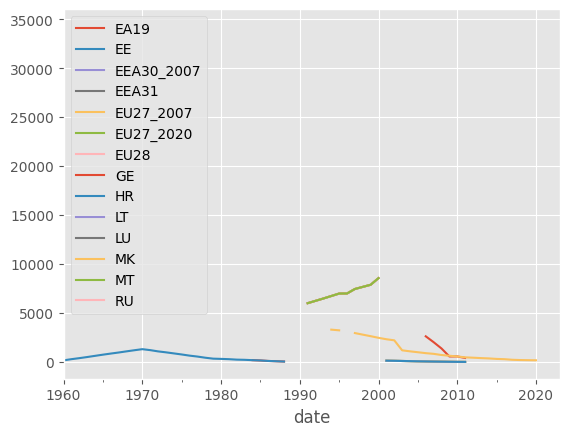

In [137]:
ds_pop.sel(age="UNK").to_dataset("location").to_dataframe().replace(0, np.nan).dropna(
    how="all", axis=1
).plot()

In [128]:
dfp = ds_pop.sel(location="FR").drop_vars("location").to_dataset("age").to_dataframe()
dfp.tail()

,TOTAL,UNK,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y92,Y93,Y94,Y95,Y96,Y97,Y98,Y99,Y_LT1,Y_OPEN
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,67290471.0,0.0,728423.0,848891.0,842416.0,853886.0,835906.0,832774.0,831456.0,838861.0,...,128755.0,105185.0,83009.0,64831.0,49050.0,37387.0,26342.0,10926.0,713104.0,18526.0
2020-01-01,67473651.0,0.0,717759.0,845299.0,849555.0,844407.0,854085.0,838293.0,836108.0,830276.0,...,129906.0,107763.0,85522.0,65563.0,50273.0,36768.0,27255.0,18722.0,708042.0,19583.0
2021-01-01,67728568.0,0.0,712862.0,858858.0,849947.0,855347.0,848424.0,861019.0,848123.0,838911.0,...,132727.0,106644.0,86828.0,66650.0,49404.0,37268.0,26325.0,18855.0,691062.0,24723.0
2022-01-01,67957053.0,0.0,695262.0,841019.0,863463.0,855092.0,858773.0,853859.0,867840.0,851498.0,...,133194.0,109791.0,86548.0,68584.0,51237.0,36770.0,27013.0,18397.0,695970.0,28897.0
2023-01-01,68172977.0,0.0,700108.0,841464.0,846547.0,869537.0,859538.0,865204.0,861713.0,872223.0,...,140505.0,109580.0,88336.0,67365.0,51884.0,37423.0,25826.0,18485.0,679984.0,29962.0


<Axes: xlabel='date'>

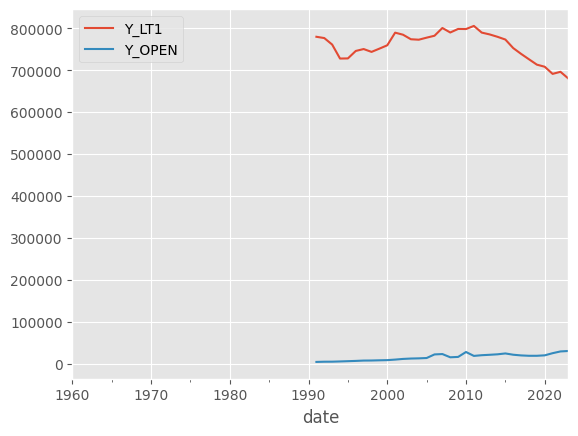

In [139]:
dfp[["Y_LT1", "Y_OPEN"]].plot()

In [160]:
dict_age_matching_pop = {
    "Age0_4": [0, 4],
    "Age5_9": [5, 9],
    "Age10_14": [10, 14],
    "Age15_17": [15, 17],
    "Age<18": [0, 17],
    "Age18_24": [18, 24],
    "Age25_49": [25, 49],
    "Age50_59": [50, 59],
    "Age60_69": [60, 69],
    "Age70_79": [70, 79],
    # "1_Age<60": [
    #     "Y_LT5",
    #     "Y5-9",
    #     "Y10-14",
    #     "Y15-19",
    #     "Y20-24",
    #     "Y25-29",
    #     "Y30-34",
    #     "Y35-39",
    #     "Y40-44",
    #     "Y45-49",
    #     "Y50-54",
    #     "Y55-59",
    # ],
    # "1_Age60+": ["Y60-64", "Y65-69", "Y70-74", "Y75-79", "Y80-84", "Y85-89", "Y_GE90"],
    "Age80+": [80, 100],
}


def format_age(age):
    ans = f"Y{age}"
    if ans == "Y0":
        ans = "Y_LT1"
    if ans == "Y100":
        ans = "Y_OPEN"
    return ans


for age_group, values in dict_age_matching_pop.items():
    # print(age_group)
    # print(values)
    values = np.arange(values[0], values[1] + 1, 1)
    values = [format_age(value) for value in values]
    # print(values)
    dict_age_matching_pop[age_group] = values

In [163]:
list_age_groups = [key for key in dict_age_matching_pop]
ds_pop_grouped = ds_pop.copy()
ds_pop_grouped = ds_pop_grouped.rename({"age": "age_year"})
ds_pop_grouped = xr.concat(
    [
        ds_pop_grouped.sel(age_year=dict_age_matching_pop[age_group])
        for age_group in list_age_groups
    ],
    dim="age",
)
ds_pop_grouped = ds_pop_grouped.assign_coords(coords={"age": list_age_groups})
ds_pop_grouped = ds_pop_grouped.sum("age_year")
ds_pop_grouped

<xarray.DataArray (age: 11, location: 59, date: 64)>
array([[[      0.,       0.,       0., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,  143546.,  138491.,
          132008.],
        [      0.,       0.,       0., ...,  185829.,       0.,
          182457.],
        ...,
        [      0.,       0.,       0., ..., 1689356., 1566776.,
               0.],
        [      0.,       0.,       0., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,  139507.,  137290.,
               0.]],

       [[      0.,       0.,       0., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,  161713.,  158578.,
          153358.],
        [      0.,       0.,       0., ...,  208316.,       0.,
          204009.],
...
        [      0.,       0.,       0., ..., 2910402., 2912917.,
               0.],
        [      0.,       0.,       0., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,   69668.,   68782.,
               0.]],

       [[      0.,       0.,       0., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,   84423.,   87070.,
           90543.],
        [      0.,       0.,       0., ...,   92438.,       0.,
          399176.],
        ...,
        [      0.,       0.,       0., ..., 1924507., 1928162.,
               0.],
        [ 300000.,  300000.,  400000., ...,       0.,       0.,
               0.],
        [      0.,       0.,       0., ...,   33467.,   33912.,
               0.]]])
Coordinates:
  * location  (location) <U10 'AD' 'AL' 'AM' 'AT' 'AZ' ... 'TR' 'UA' 'UK' 'XK'
  * date      (date) datetime64[ns] 1960-01-01 1961-01-01 ... 2023-01-01
  * age       (age) <U8 'Age0_4' 'Age5_9' 'Age10_14' ... 'Age70_79' 'Age80+'

In [169]:
list_age = [
    "Age0_4",
    "Age5_9",
    "Age10_14",
    "Age15_17",
    # "Age<18",
    "Age18_24",
    "Age25_49",
    "Age50_59",
    "Age60_69",
    "Age70_79",
    "Age80+",
]
ds_pop_grouped.sel(
    location="FR",
    age=list_age,
).sum("age")

<xarray.DataArray (date: 64)>
array([       0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.,        0.,        0.,
              0., 58313439., 58604851., 58885929., 59104320., 59315139.,
       59522297., 59726386., 59934884., 60158533., 60545022., 60979315.,
       61424036., 61864088., 62292241., 62772870., 63229635., 63645065.,
       64007193., 64350226., 64658856., 64978721., 65276983., 65600350.,
       66165980., 66458153., 66638391., 66809816., 67026224., 67290471.,
       67473651., 67728568., 67957053., 68172977.])
Coordinates:
    location  <U10 'FR'
  * date      (date) datetime64[ns] 1960-01-01 1961-01-01 ... 2023-01-01

# Data analysis

In [9]:
def get_country_name(country):
    if country != "EL":
        country_name = pycountry.countries.get(alpha_2=country).name
    else:
        country_name = "Greece"
    return country_name

## Correlation with montly excess mortality

In [10]:
def plot_excess_mortality_correlation(country):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax2 = ax.twinx()
    dfp = ds_em.sel(location=country).to_dataframe("Excess_mortality")
    dfp[["Excess_mortality"]].resample("MS").mean().plot(ax=ax, alpha=0.6)
    dfp = (
        ds_vax.NumberDosesInjected.sum("Vaccine")
        .sel(age=age, location=country)
        .to_dataframe("dose")
    )
    dfp[["dose"]].resample("MS").sum().plot(ax=ax2, c="blue", alpha=0.6)
    ax2.grid(False)
    ax2.legend(loc=1)
    ax.legend(loc=2)
    ax.set_ylabel("Excess mortality (%)")
    ax2.set_ylabel("Vaccination rollout (dose/month)")
    country_name = get_country_name(country)
    plt.suptitle(country_name)
    plt.savefig(f"plot/Excess_mortality/{country_name}.png")
    return fig, ax

In [10]:
bar = pyprind.ProgBar(len(ds_vax.location.values))
for country in ds_vax.location.values:
    fig, ax = plot_excess_mortality_correlation(country)
    plt.close()
    bar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42


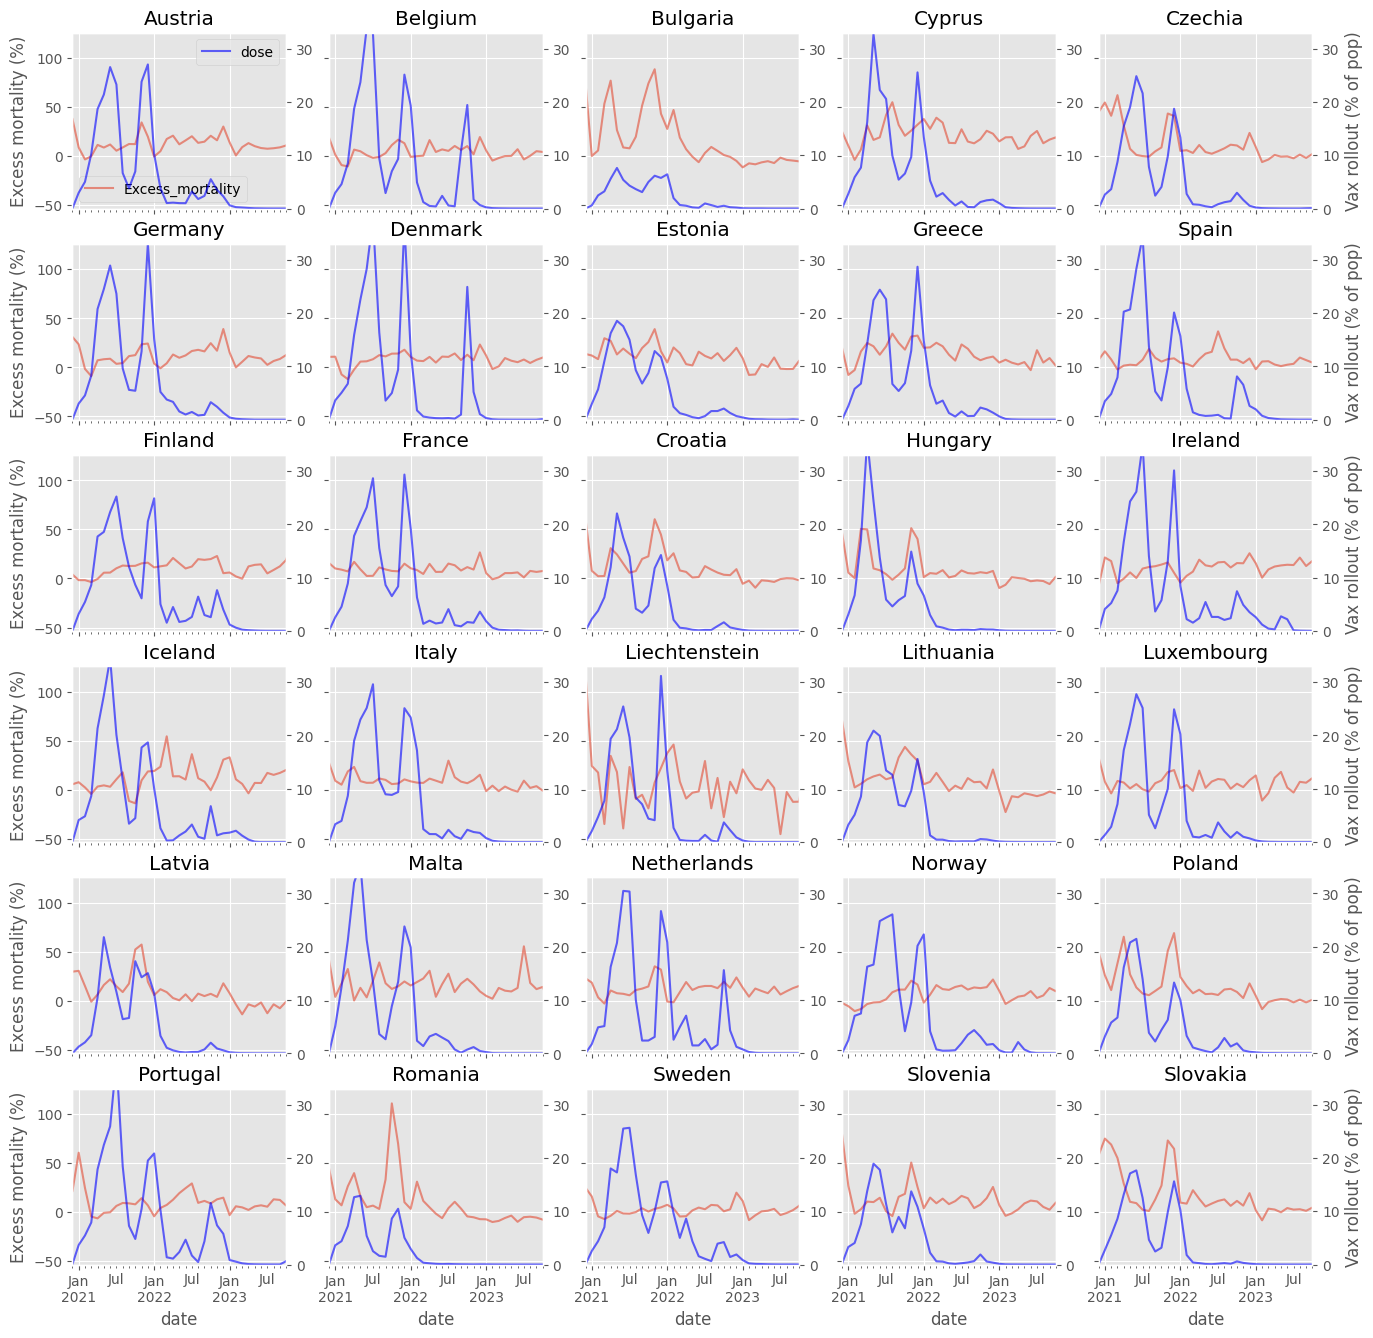

In [60]:
fig, ax = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(16, 16))
ax = ax.ravel()
for i, country in enumerate(ds_vax.location.values):
    axi = ax[i]
    axib = axi.twinx()

    dfp = ds_em.sel(location=country).to_dataframe("Excess_mortality")
    dfp[["Excess_mortality"]].plot(ax=axi, alpha=0.6, legend=False)
    dfp = (
        ds_vax.NumberDosesInjected.sum("Vaccine")
        .sel(age=age, location=country)
        .to_dataframe("dose")
    )
    population = (
        ds_vax.Population.sel(location=country, age="ALL")
        .max(["Vaccine", "date"])
        .values
    )

    (dfp[["dose"]].resample("MS").sum() / population * 100).plot(
        ax=axib, c="blue", alpha=0.6, legend=False
    )
    axib.grid(False)
    axib.set_ylim([0, 35])
    country_name = get_country_name(country)
    axi.set_title(country_name)
    if i == 0:
        axib.legend(loc=1)
        axi.legend(loc=3)
    if i % 5 == 0:
        axi.set_ylabel("Excess mortality (%)")
    if i % 5 == 4:
        axib.set_ylabel("Vax rollout (% of pop)")

## Correlation by age

In [61]:
ds_ma = xr.load_dataarray("data/ds_demo_r_mwk_05.nc")
ds_ma = ds_ma.sel(sex="T")

In [174]:
dict_age_matching = {
    "Age0_4": ["Y_LT5"],
    "Age5_9": ["Y5-9"],
    "Age10_14": ["Y10-14"],
    "Age15_17": ["Y15-19"],
    "Age<18": ["Y_LT5", "Y5-9", "Y10-14", "Y15-19"],
    "Age18_24": ["Y20-24"],
    "Age25_49": ["Y25-29", "Y30-34", "Y35-39", "Y40-44", "Y45-49"],
    "Age50_59": ["Y50-54", "Y55-59"],
    "Age60_69": ["Y60-64", "Y65-69"],
    "Age70_79": ["Y70-74", "Y75-79"],
    # "1_Age<60": [
    #     "Y_LT5",
    #     "Y5-9",
    #     "Y10-14",
    #     "Y15-19",
    #     "Y20-24",
    #     "Y25-29",
    #     "Y30-34",
    #     "Y35-39",
    #     "Y40-44",
    #     "Y45-49",
    #     "Y50-54",
    #     "Y55-59",
    # ],
    # "1_Age60+": ["Y60-64", "Y65-69", "Y70-74", "Y75-79", "Y80-84", "Y85-89", "Y_GE90"],
    "Age80+": ["Y80-84", "Y85-89", "Y_GE90"],
}

In [179]:
list_age_groups = [key for key in dict_age_matching]
ds_ma_grouped = ds_ma.copy()
ds_ma_grouped = ds_ma_grouped.rename({"age": "age_year"})
ds_ma_grouped = xr.concat(
    [
        ds_ma_grouped.sel(age_year=dict_age_matching[age_group])
        for age_group in list_age_groups
    ],
    dim="age",
)
ds_ma_grouped = ds_ma_grouped.assign_coords(coords={"age": list_age_groups})
ds_ma_grouped = ds_ma_grouped.sum("age_year")
ds_ma_grouped

<xarray.DataArray (age: 11, location: 39, date: 1282)>
array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  3.,   2.,   0., ...,   2.,   1.,   0.],
        [ 15.,  11.,  12., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   1.,   0.,   0.],
        [  1.,   1.,   3., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
...
        ...,
        [ 73.,  81.,  77., ...,  61.,  47.,   0.],
        [210., 223., 219., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [127., 129., 158., ...,  86.,  82.,   0.],
        [358., 353., 406., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [141., 168., 173., ..., 207., 227.,   0.],
        [323., 308., 399., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]])
Coordinates:
  * location  (location) <U9 'AD' 'AL' 'AM' 'AT' 'BE' ... 'SE' 'SI' 'SK' 'UK'
  * date      (date) datetime64[ns] 2000-01-02 2000-01-09 ... 2024-07-21
    sex       <U1 'T'
  * age       (age) <U8 'Age0_4' 'Age5_9' 'Age10_14' ... 'Age70_79' 'Age80+'

In [197]:
ds_ma_n = ds_ma_grouped.resample(date="W").mean() / ds_pop_grouped.resample(
    date="W"
).interpolate("linear")
ds_vax_n = ds_vax.resample(date="W").mean() / ds_pop_grouped.resample(
    date="W"
).interpolate("linear")

In [205]:
country = "FR"


def plot_normalised_mortality_correlation_by_age(
    country, start_date=None, timestep="W"
):
    fig, ax = plt.subplots(4, 3, figsize=(16, 9), sharex=True)
    ax = ax.ravel()
    ax[0].grid(False)
    ax[0].axis("off")

    country_name = get_country_name(country)
    ax[0].set_title(
        f"Correlation of normalised mortality \n and vaccination rollout \nin {country_name}",
        y=0.2,
        fontsize=25,
    )

    for i, (age_cat, list_age) in enumerate(dict_age_matching.items()):
        if i == 0:
            legend = True
        else:
            legend = False
        axi = ax[i + 1]
        axib = axi.twinx()
        dfp = (
            ds_ma_n.sel(location=country, age=age_cat)
            .resample(date=timestep)
            .mean()
            .to_dataframe("mortality")
        )
        dfp[["mortality"]].plot(ax=axi, alpha=0.6, legend=legend, zorder=2)
        dfp = (
            ds_vax_n.sel(location=country, age=age_cat)
            .sum("Vaccine")
            .resample(date=timestep)
            .mean()
            .NumberDosesInjected.to_dataframe("dose")
        )
        dfp[["dose"]].plot(ax=axib, c="blue", alpha=0.6, legend=legend, zorder=1)
        if legend:
            axib.legend(loc=4)
            axi.legend(loc=3)
        axi.set_ylabel("Mortality normalized")
        axib.set_ylabel("dose normalized")
        axi.set_title(f"{age_cat}:{str(list_age)}")
        axib.grid(False)
        # print(list_age)
        if start_date != None:
            axi.set_xlim([start_date, axi.get_xlim()[1]])
            axib.set_xlim([start_date, axi.get_xlim()[1]])
    plt.tight_layout()
    plt.savefig(
        f"plot/Excess_mortality_by_age/{country_name}_{timestep}.png",
        bbox_inches="tight",
    )
    return fig, ax

(<Figure size 1600x900 with 23 Axes>,
 array([<Axes: title={'center': 'Correlation of normalised mortality \n and vaccination rollout \nin France'}>,
        <Axes: title={'center': "Age0_4:['Y_LT5']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age5_9:['Y5-9']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age10_14:['Y10-14']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age15_17:['Y15-19']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age<18:['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age18_24:['Y20-24']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age25_49:['Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age50_59:['Y50-54', 'Y55-59']"}, xlabe

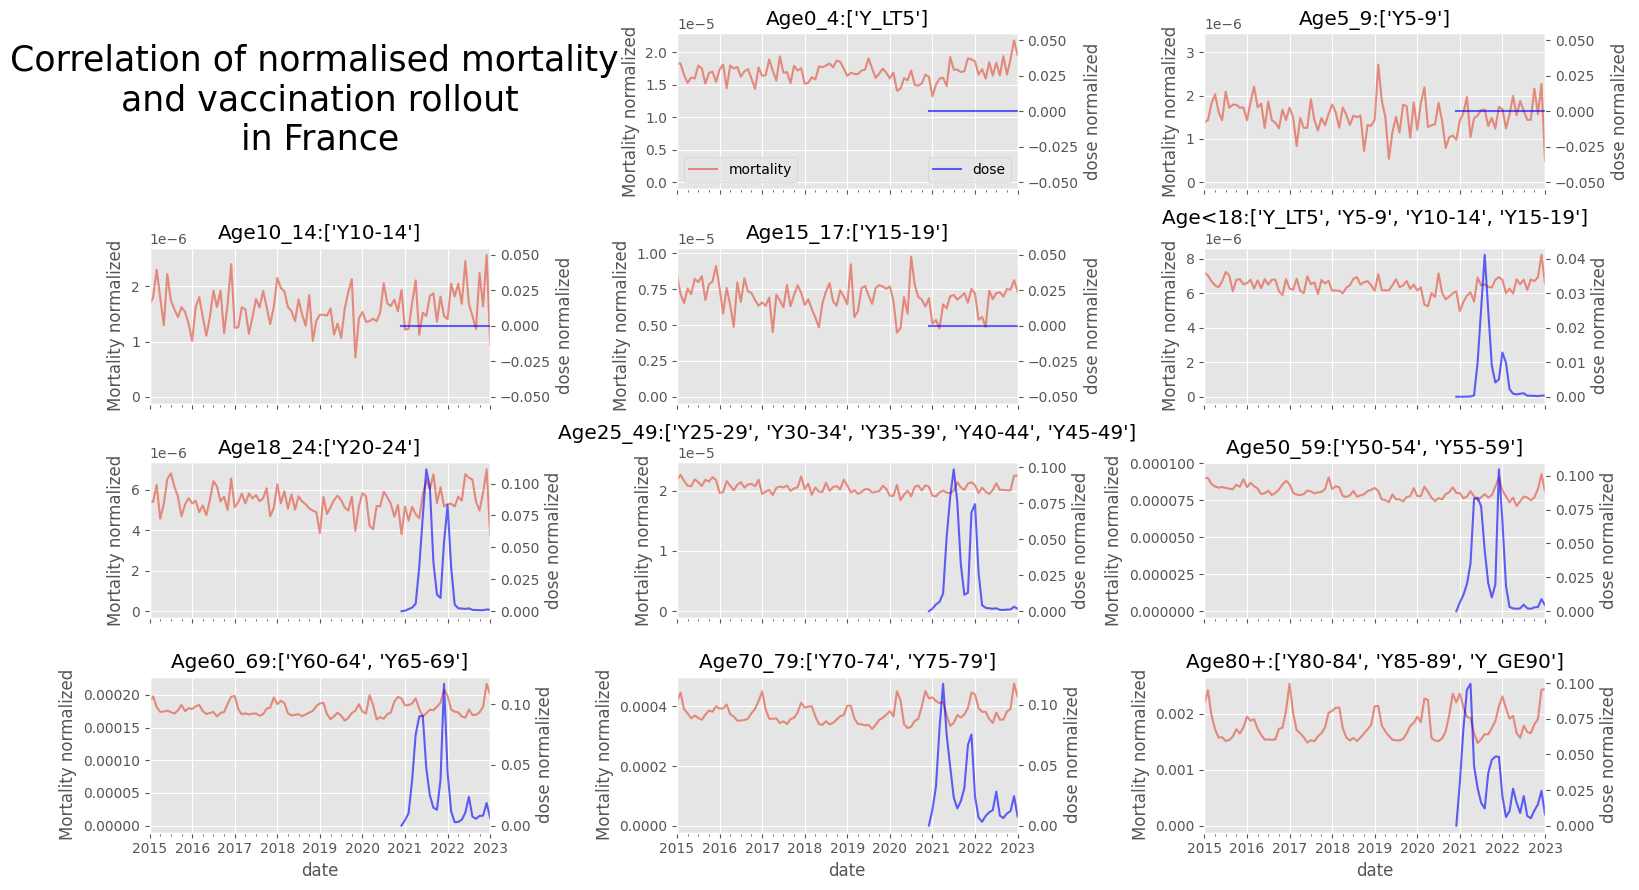

In [207]:
plot_normalised_mortality_correlation_by_age(
    country="FR", start_date="2015-01-01", timestep="M"
)

(<Figure size 1600x900 with 23 Axes>,
 array([<Axes: title={'center': 'Correlation of normalised mortality \n and vaccination rollout \nin Italy'}>,
        <Axes: title={'center': "Age0_4:['Y_LT5']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age5_9:['Y5-9']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age10_14:['Y10-14']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age15_17:['Y15-19']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age<18:['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age18_24:['Y20-24']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age25_49:['Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49']"}, xlabel='date', ylabel='Mortality normalized'>,
        <Axes: title={'center': "Age50_59:['Y50-54', 'Y55-59']"}, xlabel

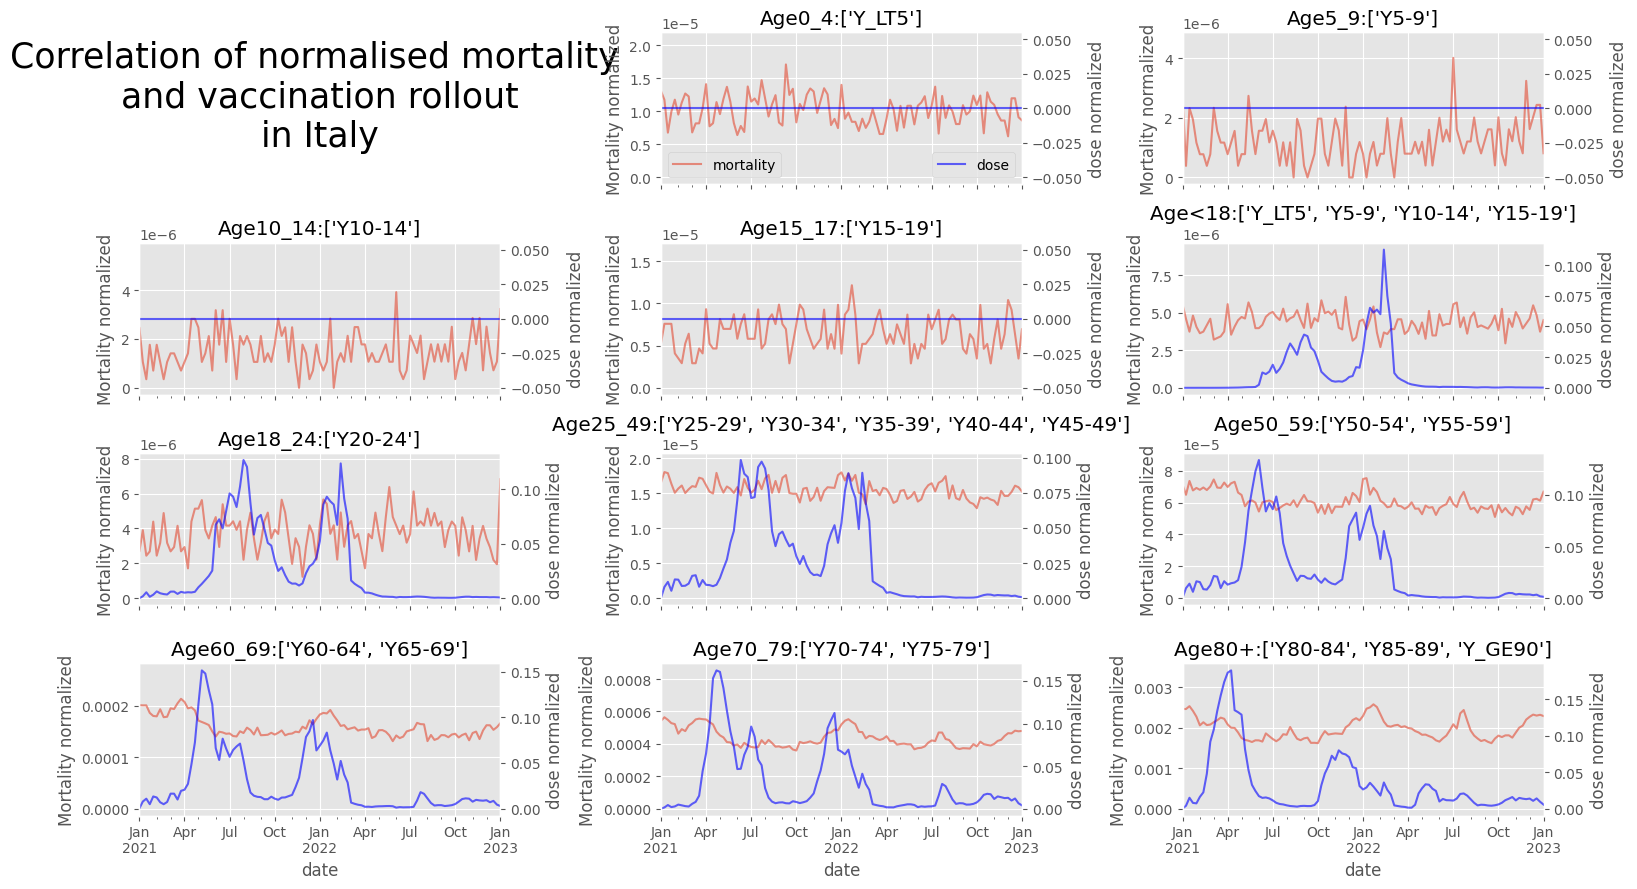

In [210]:
plot_normalised_mortality_correlation_by_age(
    country="IT", start_date="2021-01-01", timestep="W"
)

In [170]:
country = "FR"


def get_population(country, age):
    pop = (
        ds_vax.sel(location=country, age=age)
        .max("Vaccine")[["Denominator", "Population"]]
        .mean("date")
        .Population
    )
    if np.isnan(pop):
        pop = 0
    pop = np.max([1, pop])
    return pop


def plot_excess_mortality_correlation_by_age(country, start_date=None, timestep="W"):
    fig, ax = plt.subplots(4, 3, figsize=(16, 9), sharex=True)
    ax = ax.ravel()
    ax[0].grid(False)
    ax[0].axis("off")

    country_name = get_country_name(country)
    ax[0].set_title(
        f"Correlation of mortality \n and vaccination rollout \nin {country_name}",
        y=0.2,
        fontsize=25,
    )

    for i, (age_cat, list_age) in enumerate(dict_age_matching.items()):
        if i == 0:
            legend = True
        else:
            legend = False
        pop = get_population(country, age_cat)
        axi = ax[i + 1]
        axib = axi.twinx()
        dfp = (
            ds_ma.sel(location=country, age=list_age)
            .sum("age")
            .to_dataframe("mortality")
        )
        (dfp[["mortality"]].resample(timestep).mean() / pop).plot(
            ax=axi, alpha=0.6, legend=legend
        )
        dfp = (
            ds_vax.sel(location=country, age=age_cat)
            .sum("Vaccine")
            .NumberDosesInjected.to_dataframe("dose")
        )
        (dfp[["dose"]].resample(timestep).mean() / pop).plot(
            ax=axib, c="blue", alpha=0.6, legend=legend
        )
        if legend:
            axib.legend(loc=0)
            axi.legend(loc=3)
        axi.set_ylabel("Mortality normalized")
        axib.set_ylabel("dose normalized")
        axi.set_title(f"{age_cat}:{str(list_age)}")
        axib.grid(False)
        # print(list_age)
        if start_date != None:
            axi.set_xlim([start_date, axi.get_xlim()[1]])
            axib.set_xlim([start_date, axi.get_xlim()[1]])
    plt.tight_layout()
    plt.savefig(
        f"plot/Excess_mortality_by_age/{country_name}_{timestep}.png",
        bbox_inches="tight",
    )
    return fig, ax

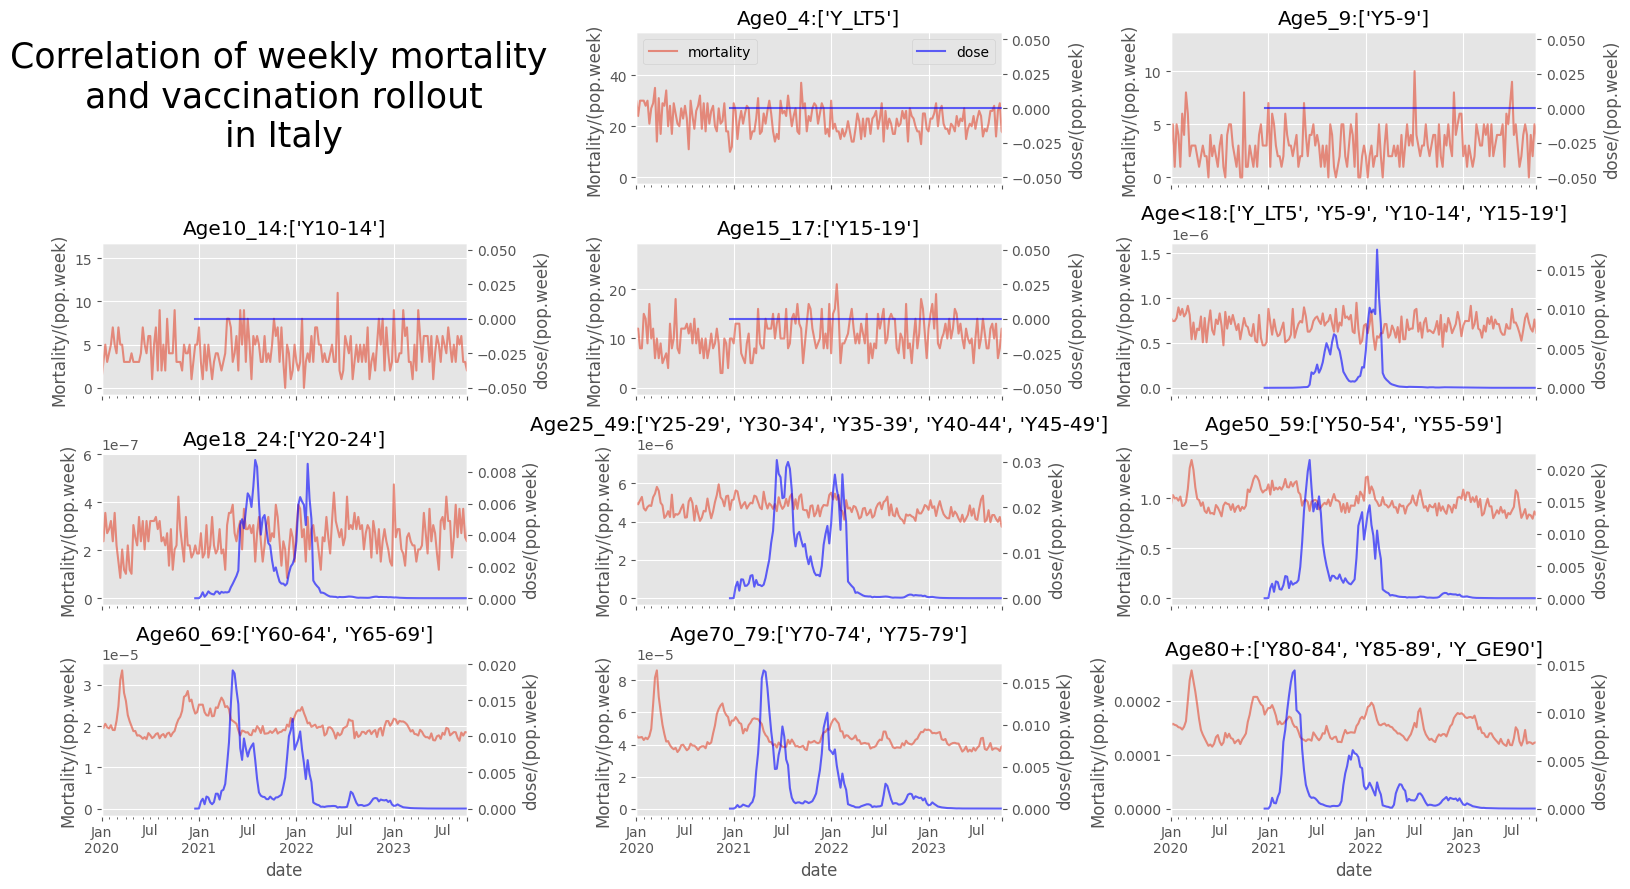

In [112]:
fig, ax = plot_excess_mortality_correlation_by_age("IT", start_date="2020-01-01")

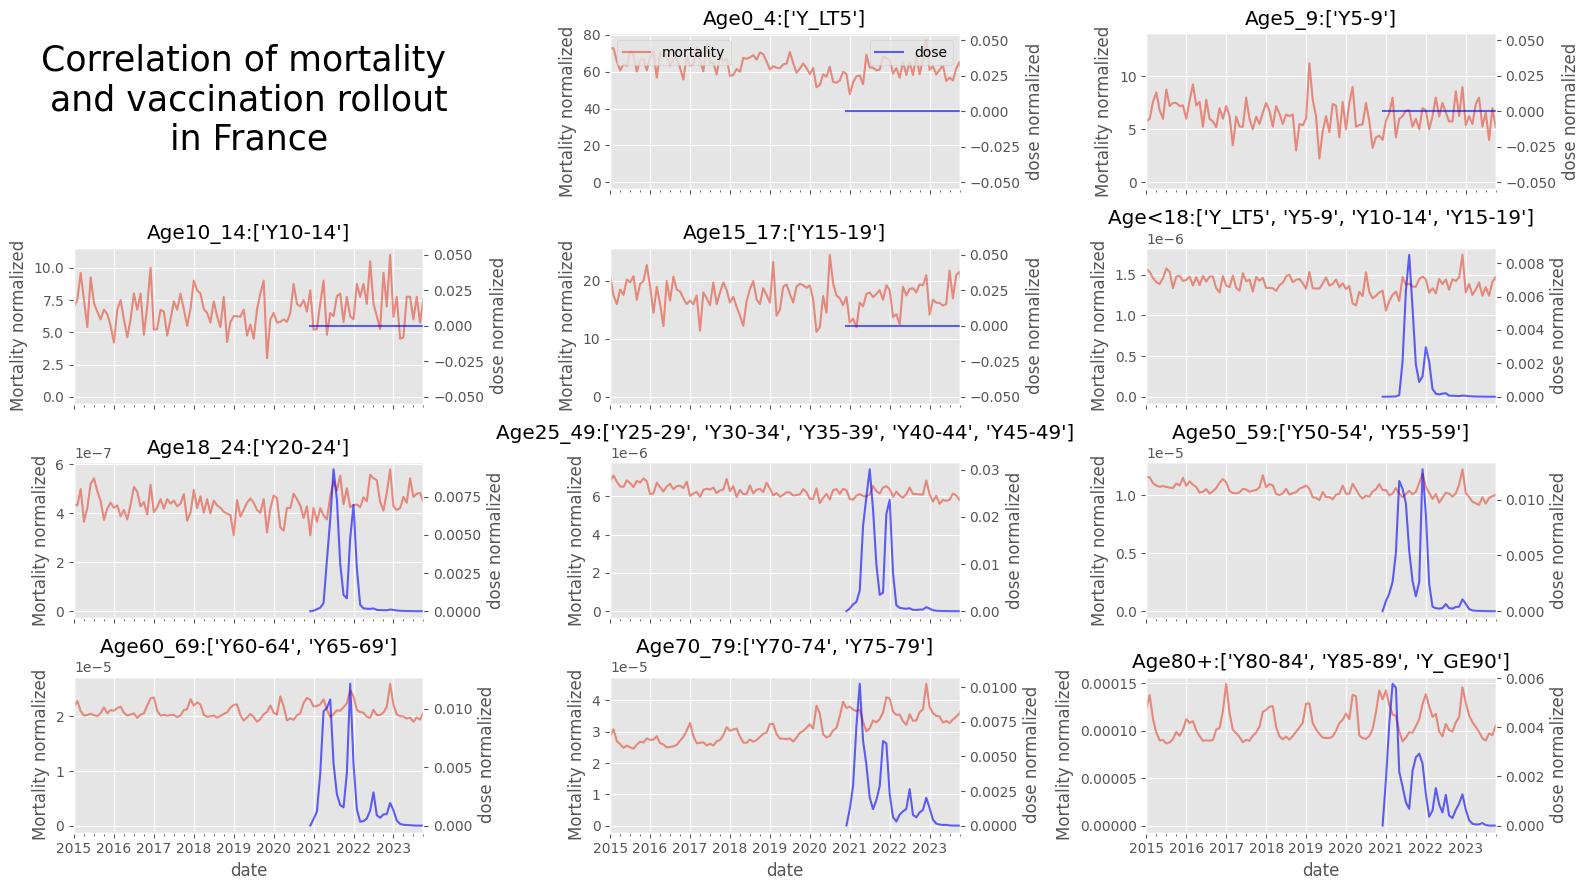

In [118]:
fig, ax = plot_excess_mortality_correlation_by_age(
    "FR", start_date="2015-01-01", timestep="M"
)

In [ ]:
bar = pyprind.ProgBar(len(ds_vax.location.values))
for country in ds_vax.location.values:
    fig, ax = plot_normalised_mortality_correlation_by_age(
        country=country, start_date="2015-01-01", timestep="M"
    )
    fig, ax = plot_excess_mortality_correlation_by_age(country)
    plt.close()
    bar.update()

# Focus on age category

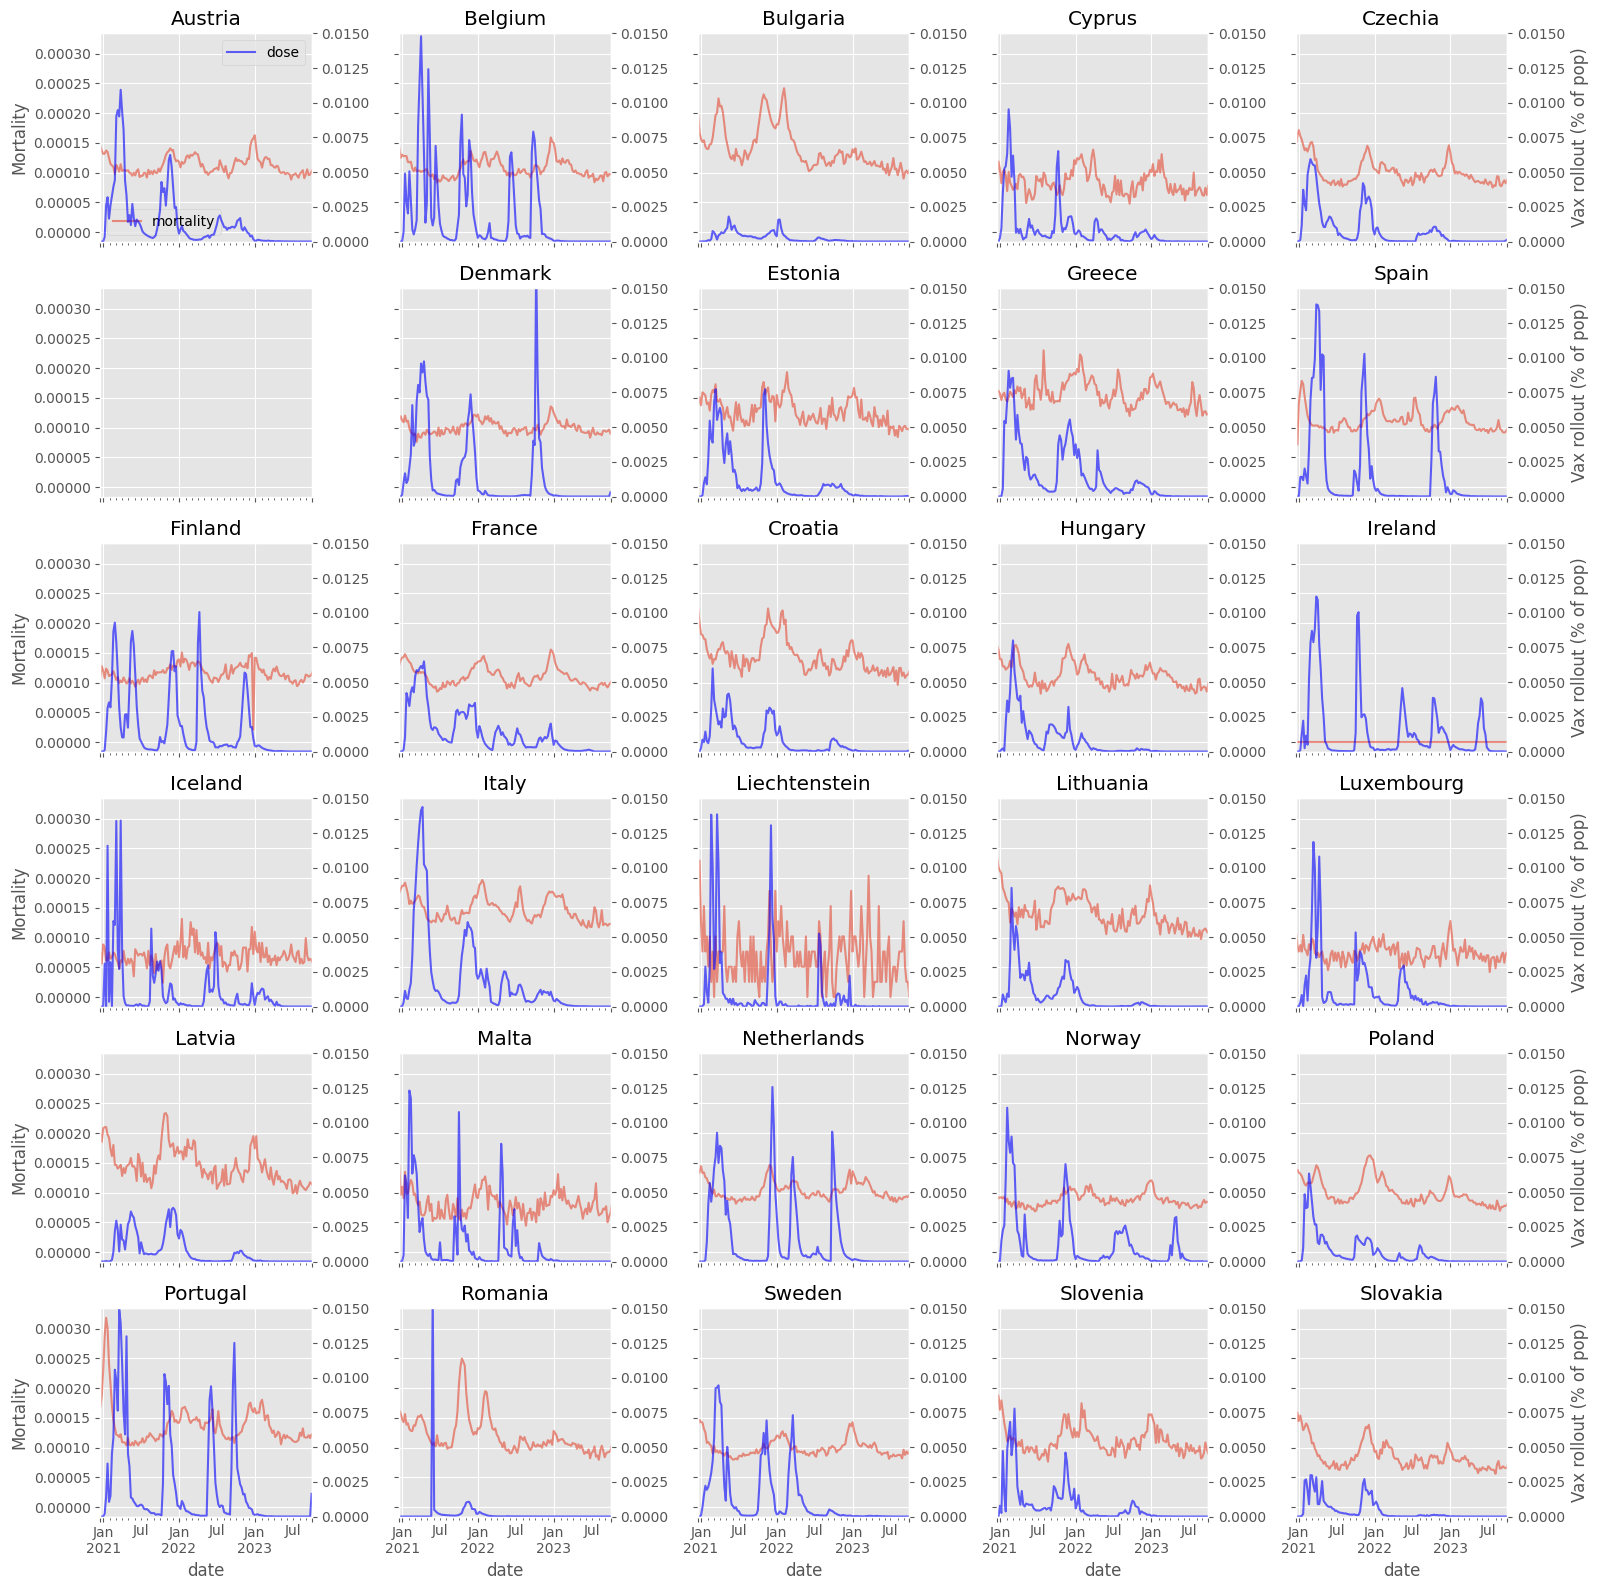

In [109]:
age = "Age80+"

list_age = dict_age_matching[age]

fig, ax = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(16, 16))
ax = ax.ravel()
for i, country in enumerate(ds_vax.location.values):
    if country == "DE":
        continue
    axi = ax[i]
    axib = axi.twinx()
    pop = get_population(country, age)
    # Mortality
    dfp = ds_ma.sel(location=country, age=list_age).sum("age").to_dataframe("mortality")
    (dfp[["mortality"]].resample("W").mean() / pop).plot(
        ax=axi, alpha=0.6, legend=False
    )
    # Vax injection
    dfp = (
        ds_vax.sel(location=country, age=age)
        .sum("Vaccine")
        .NumberDosesInjected.to_dataframe("dose")
    )
    (dfp[["dose"]].resample("W").mean() / pop).plot(
        ax=axib, c="blue", alpha=0.6, legend=False
    )
    axib.grid(False)
    axib.set_ylim([0, 0.015])
    # Label, title, etc
    country_name = get_country_name(country)
    axi.set_title(country_name)
    if i == 0:
        axib.legend(loc=1)
        axi.legend(loc=3)
    if i % 5 == 0:
        axi.set_ylabel("Mortality")
    if i % 5 == 4:
        axib.set_ylabel("Vax rollout (% of pop)")
plt.tight_layout()

# DTW

In [186]:
from dtw import dtw, rabinerJuangStepPattern

In [187]:
country = "IT"
age = "Age80+"

list_age = dict_age_matching[age]

dfp_mortality = (
    ds_ma.sel(location=country, age=list_age).sum("age").to_dataframe("mortality")
)
dfp_dose = (
    ds_vax.sel(location=country, age=age)
    .sum("Vaccine")
    .NumberDosesInjected.to_dataframe("dose")
)
df = pd.concat([dfp_mortality.mortality, dfp_dose.dose], axis=1)
df = df["2022-06":"2023-06"].resample("W").mean()
# df = df.resample("2W").mean()
df = df / df.max()
df.head()

,mortality,dose
date,,
2022-06-05,0.679178,0.469029
2022-06-12,0.712442,0.636869
2022-06-19,0.740525,0.555635
2022-06-26,0.794692,0.548863
2022-07-03,0.855221,0.530074


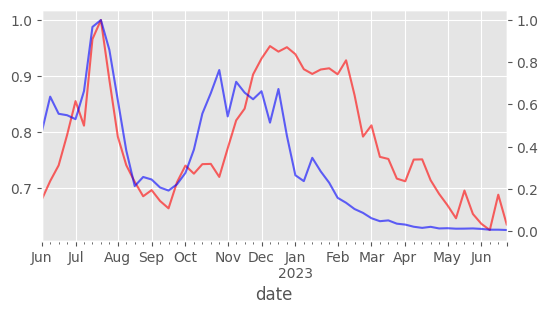

In [188]:
fig, ax = plt.subplots(figsize=(6, 3))
axb = ax.twinx()
df.mortality.plot(ax=ax, c="r", alpha=0.6)
df.dose.plot(ax=axb, c="b", alpha=0.6)
axb.grid(False)

<Axes: xlabel='Index', ylabel='Query value'>

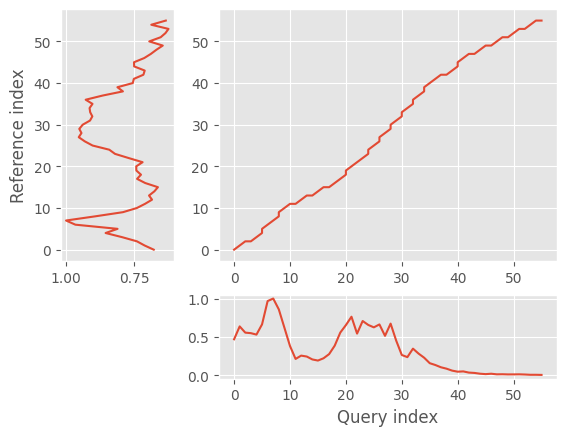

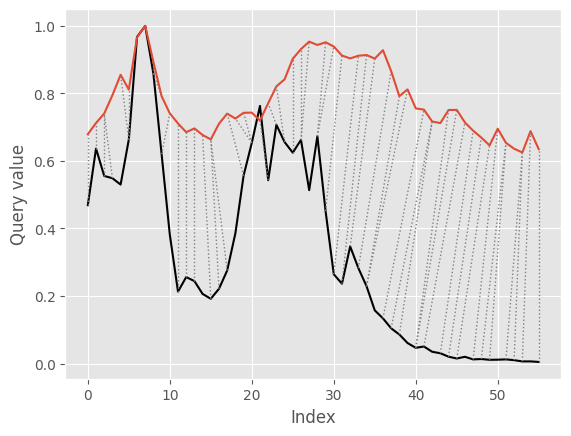

In [189]:
r = dtw(
    x=df.dose,
    y=df.mortality,
    keep_internals=True,
    step_pattern=rabinerJuangStepPattern(6, "c"),
    window_type="sakoechiba",
    window_args={"window_size": 10},
)
r.plot(type="threeway")
r.plot(type="twoway")
# r.plot(type="density")
# window_type="sakoechiba", window_args={'window_size': 10})